In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from collections import Counter
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
%load_ext autoreload
%autoreload

In [2]:
base_path = Path('../input/chexpert-v10-small')
train_data_path = base_path / 'train'
test_data_path = base_path / 'test'
train_labels_path = base_path / 'train_labels.csv'

def load_data(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

train_df = load_data(base_path / 'CheXpert-v1.0-small/train.csv')
valid_df = load_data(base_path / 'CheXpert-v1.0-small/valid.csv')

if train_df is not None:
    print("Training data loaded successfully.")
else:
    print("Failed to load training data.")

if valid_df is not None:
    print("Validation data loaded successfully.")
else:
    print("Failed to load validation data.")

Training data loaded successfully.
Validation data loaded successfully.


In [3]:
chexnet_targets = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                   'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                   'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                   'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [4]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [6]:
def feature_string(row):
    active_features = [
        feature for feature in u_one_features if row[feature] in [-1, 1]
    ] + [
        feature for feature in u_zero_features if row[feature] == 1
    ]
    
    return ';'.join(active_features)

In [7]:
train_df['train_valid'] = False
valid_df['train_valid'] = True

In [8]:
train_df['patient'] = train_df['Path'].str.split('/', expand=True)[2]
train_df['study'] = train_df['Path'].str.split('/', expand=True)[3]

valid_df['patient'] = valid_df['Path'].str.split('/', expand=True)[2]
valid_df['study'] = valid_df['Path'].str.split('/', expand=True)[3]

In [9]:
df = pd.concat([train_df, valid_df])
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [24]:
def feature_string(row):
    active_features = [
        feature for feature in u_one_features if row[feature] in [-1, 1]
    ] + [
        feature for feature in u_zero_features if row[feature] == 1
    ]
    
    if len(active_features) == 0:
        return None
    
    return ';'.join(active_features)

df['feature_string'] = df.apply(feature_string, axis=1)
df = df[df['feature_string'].notna()]
df['feature_string'] = df['feature_string'].apply(lambda x: x.split(";"))
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,"[Atelectasis, Edema]"
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,[Edema]
12,CheXpert-v1.0-small/train/patient00007/study1/...,Male,69,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,1.0,1.0,0.0,NaN,0.0,1.0,False,patient00007,study1,"[Atelectasis, Cardiomegaly]"
13,CheXpert-v1.0-small/train/patient00007/study2/...,Male,69,Frontal,AP,NaN,1.0,NaN,1.0,NaN,...,1.0,0.0,0.0,NaN,0.0,1.0,False,patient00007,study2,[Atelectasis]
14,CheXpert-v1.0-small/train/patient00008/study1/...,Male,81,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,False,patient00008,study1,[Pleural Effusion]


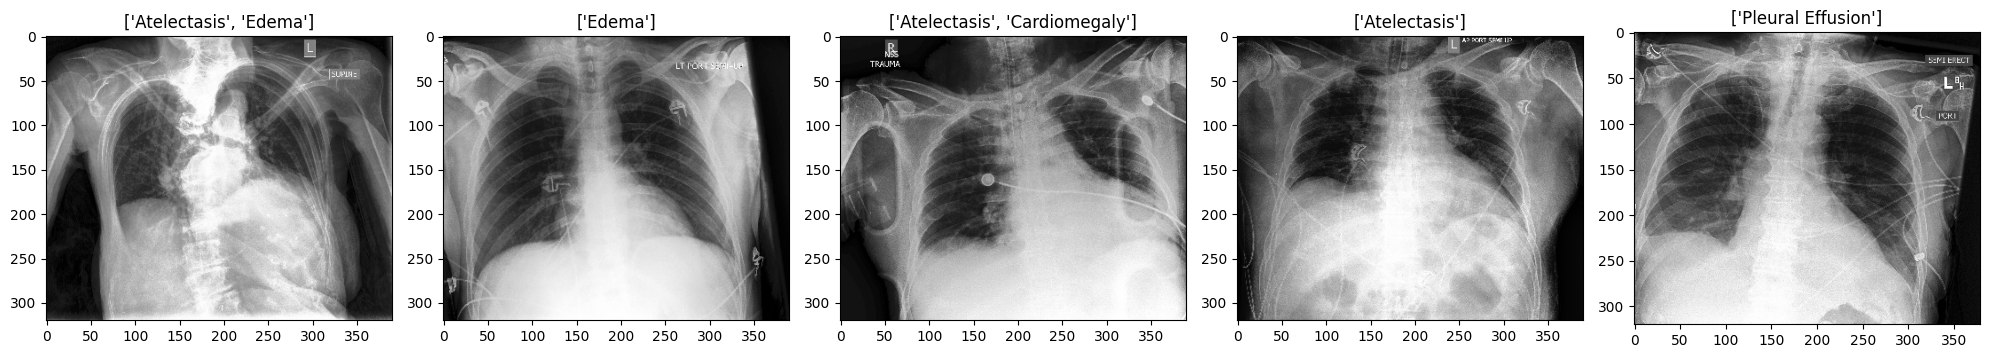

In [25]:
image_paths = df['Path'].head(5)
image_labels = df['feature_string'].head(5)
fig, axes = plt.subplots(1, len(image_labels), figsize=(20, 10))
for ax, path, label in zip(axes, image_paths, image_labels):
    image = cv2.imread(os.path.join(base_path, path))
    ax.imshow(image)
    ax.set_title(label)
plt.tight_layout()
plt.show()

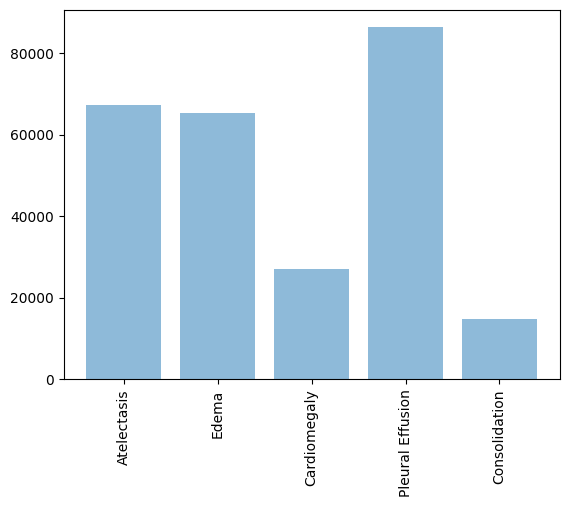

In [26]:
all_labels = [label for chexpert_targets in df['feature_string'] for label in chexpert_targets]
label_counts = Counter(all_labels)
plt.bar(label_counts.keys(), label_counts.values(), alpha=0.5)
plt.xticks(rotation='vertical')
plt.show()

In [27]:
sample_percentage = 0.00
train_df1 = df[~df['train_valid']]
valid_df1 = df[df['train_valid']]
unique_patients = train_df1['patient'].unique()
sample_mask = np.random.rand(len(unique_patients)) < sample_percentage
sampled_patients = unique_patients[sample_mask]
dev_set = train_df1[train_df1['patient'].isin(sampled_patients)]
train_set = train_df1[~train_df1['patient'].isin(sampled_patients)]
print(f"Validation set size: {valid_df1['Path'].size}")
print(f"Training set size: {train_set['Path'].size}")

Validation set size: 137
Training set size: 157281


In [28]:
train_set = train_set.sample(n=20000, random_state=42)

In [29]:
print(f"Training set size: {train_set['Path'].size}")

Training set size: 20000


In [30]:
datagen= ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1)
test_datagen= ImageDataGenerator(rescale=1./255)

In [32]:
def generate_datasets(image_size = 75):

    train_generator=datagen.flow_from_dataframe(dataframe=train_set, directory=base_path, 
                                                x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "training")

    validation_generator = datagen.flow_from_dataframe(dataframe=train_set, directory=base_path, 
                                                       x_col="Path", y_col="feature_string", has_ext=True, seed = 42, #classes = chexpert_targets,
                                                       class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "validation")

    test_generator = test_datagen.flow_from_dataframe(dataframe=valid_df1, directory=base_path, 
                                                      target_size=(image_size,image_size),class_mode='categorical',
                                                      batch_size=1, shuffle=False,
                                                      x_col="Path", y_col="feature_string")
    
    return [train_generator,validation_generator,test_generator]

In [33]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras import backend as K

## EfficientNet

In [40]:
def build_model(image_size = 75, load_previous_weights = True, freeze_cnn = False):
    base_model = EfficientNetB0(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if freeze_cnn:
        for layer in base_model.layers:
            layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy', AUC()])
    return model

In [41]:
image_size_input = 75
model = build_model(image_size=image_size_input)

In [36]:
datasets = generate_datasets(image_size=image_size_input)
train_generator, validation_generator, test_generator = datasets

Found 18000 validated image filenames belonging to 5 classes.
Found 2000 validated image filenames belonging to 5 classes.
Found 137 validated image filenames belonging to 5 classes.


In [42]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 75, 75, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 75, 75, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 75, 75, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 77, 77, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 38, 38, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 38, 38, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 38, 38, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 38, 38, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 38, 38, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 38, 38, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,894,824 (22.49 MB)

 Trainable params: 5,849,729 (22.31 MB)

 Non-trainable params: 45,095 (176.16 KB)

In [43]:
epochs = 10
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

In [44]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID, epochs=epochs)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 271s 367ms/step - accuracy: 0.2722 - auc_1: 0.5454 - loss: 3.7817 - val_accuracy: 0.2233 - val_auc_1: 0.4999 - val_loss: 2.6692
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4062 - auc_1: 0.5317 - loss: 2.9650 - val_accuracy: 0.1250 - val_auc_1: 0.5000 - val_loss: 2.5256
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 96s 168ms/step - accuracy: 0.3928 - auc_1: 0.5418 - loss: 3.7601 - val_accuracy: 0.4284 - val_auc_1: 0.5478 - val_loss: 3.6573
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 75us/step - accuracy: 0.3438 - auc_1: 0.5115 - loss: 4.3754 - val_accuracy: 0.4375 - val_auc_1: 0.5781 - val_loss: 5.5835
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 88s 155ms/step - accuracy: 0.4215 - auc_1: 0.5373 - loss: 4.5488 - val_accuracy: 0.4279 - val_auc_1: 0.5490 - val_loss: 5.1208
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.3750 - auc_1: 0.5715 - loss: 6.4118 - val_accuracy: 0.5000 - val_auc_1: 0.5687 - val_loss: 3.1182
Epoc

In [45]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5507 - auc_1: 0.6523 - loss: 8.4281
Test Loss: 8.221495628356934
Test Accuracy: 0.5839415788650513
Test AUC: 0.6373023390769958


In [48]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.subplot(1, 3, 2)
    plt.plot(history.history['auc_1'], label='Train AUC')
    plt.plot(history.history['val_auc_1'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('AUC over Epochs')
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.tight_layout()
    plt.show()

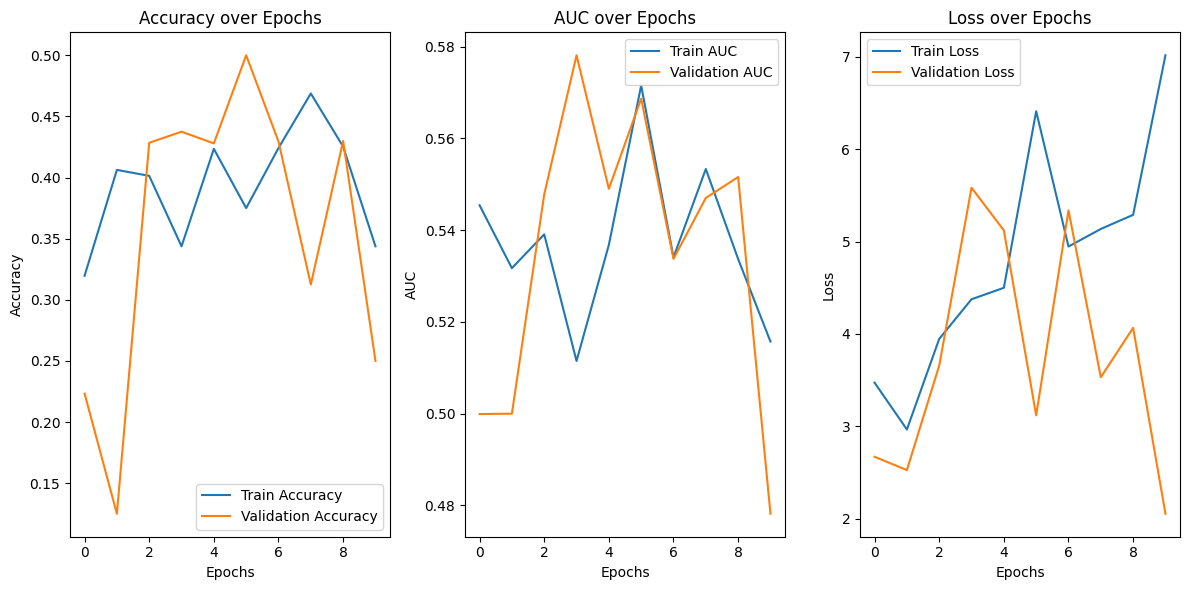

In [49]:
plot_training_history(history)

In [50]:
test_generator.reset() 
predictions = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes

137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [51]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

true_classes_binary = mlb.fit_transform(true_classes)
predicted_classes_binary = mlb.transform(predicted_classes)

print("Classification Report:")
print(classification_report(true_classes_binary, predicted_classes_binary, target_names=test_generator.class_indices.keys()))

Classification Report:
                  precision    recall  f1-score   support

     Atelectasis       0.43      0.31      0.36        80
    Cardiomegaly       0.62      0.72      0.67        68
   Consolidation       0.00      0.00      0.00        33
           Edema       0.00      0.00      0.00        45
Pleural Effusion       0.00      0.00      0.00        67

       micro avg       0.54      0.25      0.34       293
       macro avg       0.21      0.21      0.21       293
    weighted avg       0.26      0.25      0.25       293
     samples avg       0.54      0.29      0.35       293



## DenseNet121

In [54]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

def build_model_densenet(image_size = 75, load_previous_weights = True, freeze_cnn = False):
    base_model = DenseNet121(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if freeze_cnn:
        for layer in base_model.layers:
            layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

    return model

In [55]:
image_size_input = 75
model = build_model_densenet(image_size=image_size_input)

In [56]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 81, 81, 3)      │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 38, 38, 64)     │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 38, 38, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 38, 38, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 40, 40, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 19, 19, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 19, 19, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 19, 19, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 19, 19, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 19, 19, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 19, 19, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 19, 19, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 19, 19, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,620,613 (32.89 MB)

 Trainable params: 8,533,893 (32.55 MB)

 Non-trainable params: 86,720 (338.75 KB)

In [57]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID, epochs=epochs)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 299s 311ms/step - accuracy: 0.2620 - auc_2: 0.5425 - loss: 3.6651 - val_accuracy: 0.3810 - val_auc_2: 0.4856 - val_loss: 63.1485
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4688 - auc_2: 0.4850 - loss: 3.4475 - val_accuracy: 0.5625 - val_auc_2: 0.5135 - val_loss: 14.5919
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 92s 161ms/step - accuracy: 0.3995 - auc_2: 0.5294 - loss: 3.6337 - val_accuracy: 0.4289 - val_auc_2: 0.5061 - val_loss: 5.2290
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.3750 - auc_2: 0.5399 - loss: 2.8743 - val_accuracy: 0.3750 - val_auc_2: 0.5133 - val_loss: 7.1028
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 87s 152ms/step - accuracy: 0.4231 - auc_2: 0.5224 - loss: 4.2456 - val_accuracy: 0.4264 - val_auc_2: 0.5178 - val_loss: 5.5154
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.3750 - auc_2: 0.5160 - loss: 3.1838 - val_accuracy: 0.5625 - val_auc_2: 0.5178 - val_loss: 3.3504


In [61]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5507 - auc_2: 0.5956 - loss: 13.7043
Test Loss: 14.177179336547852
Test Accuracy: 0.5839415788650513
Test AUC: 0.5838876962661743


In [59]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.subplot(1, 3, 2)
    plt.plot(history.history['auc_2'], label='Train AUC')
    plt.plot(history.history['val_auc_2'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('AUC over Epochs')
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.tight_layout()
    plt.show()

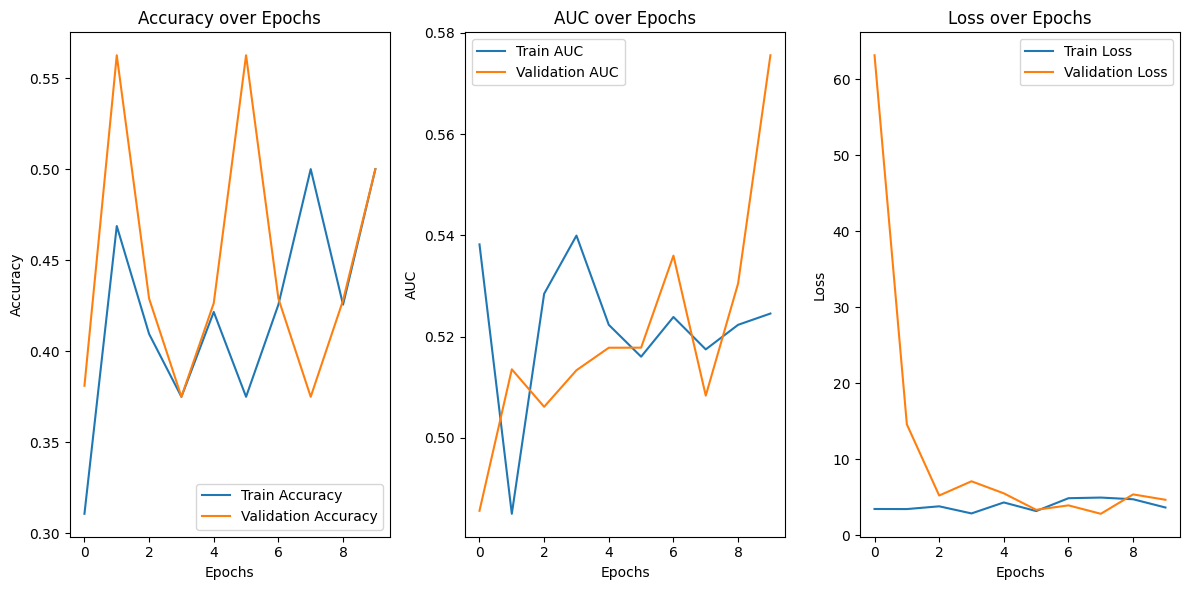

In [60]:
plot_training_history(history)

In [62]:
test_generator.reset() 
predictions = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes

137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


In [63]:
mlb = MultiLabelBinarizer()

true_classes_binary = mlb.fit_transform(true_classes)
predicted_classes_binary = mlb.transform(predicted_classes)

print("Classification Report:")
print(classification_report(true_classes_binary, predicted_classes_binary, target_names=test_generator.class_indices.keys()))

Classification Report:
                  precision    recall  f1-score   support

     Atelectasis       0.43      0.20      0.27        80
    Cardiomegaly       0.52      0.76      0.62        68
   Consolidation       0.00      0.00      0.00        33
           Edema       0.00      0.00      0.00        45
Pleural Effusion       0.00      0.00      0.00        67

       micro avg       0.50      0.23      0.32       293
       macro avg       0.19      0.19      0.18       293
    weighted avg       0.24      0.23      0.22       293
     samples avg       0.50      0.25      0.32       293



## Custom CNN

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [64]:
def build_model_cnn(image_size=75, num_classes=5, load_previous_weights=True, freeze_cnn=False):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

    return model

In [70]:
image_size_input = 75
model = build_model_cnn(image_size=image_size_input)

In [71]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,050,309 (26.89 MB)

 Trainable params: 7,047,237 (26.88 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [72]:
epochs = 10
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

In [73]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID, epochs=epochs)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 116s 194ms/step - accuracy: 0.2350 - auc_4: 0.5955 - loss: 3.7551 - val_accuracy: 0.1527 - val_auc_4: 0.6491 - val_loss: 3.7681
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - auc_4: 0.6511 - loss: 3.6947 - val_accuracy: 0.3125 - val_auc_4: 0.7171 - val_loss: 2.7694
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 96s 170ms/step - accuracy: 0.2549 - auc_4: 0.6718 - loss: 3.3220 - val_accuracy: 0.3594 - val_auc_4: 0.6720 - val_loss: 3.0273
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - accuracy: 0.2188 - auc_4: 0.6198 - loss: 3.6669 - val_accuracy: 0.2500 - val_auc_4: 0.7338 - val_loss: 2.5712
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 94s 166ms/step - accuracy: 0.2458 - auc_4: 0.6691 - loss: 3.6832 - val_accuracy: 0.2041 - val_auc_4: 0.7252 - val_loss: 4.2072
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.2500 - auc_4: 0.6977 - loss: 2.9602 - val_accuracy: 0.1875 - val_auc_4: 0.7688 - val_loss: 2.0792
Ep

In [74]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1388 - auc_4: 0.5471 - loss: 6.9878
Test Loss: 7.517389297485352
Test Accuracy: 0.1386861354112625
Test AUC: 0.5769920945167542


In [75]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.subplot(1, 3, 2)
    plt.plot(history.history['auc_4'], label='Train AUC')
    plt.plot(history.history['val_auc_4'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('AUC over Epochs')
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.tight_layout()
    plt.show()

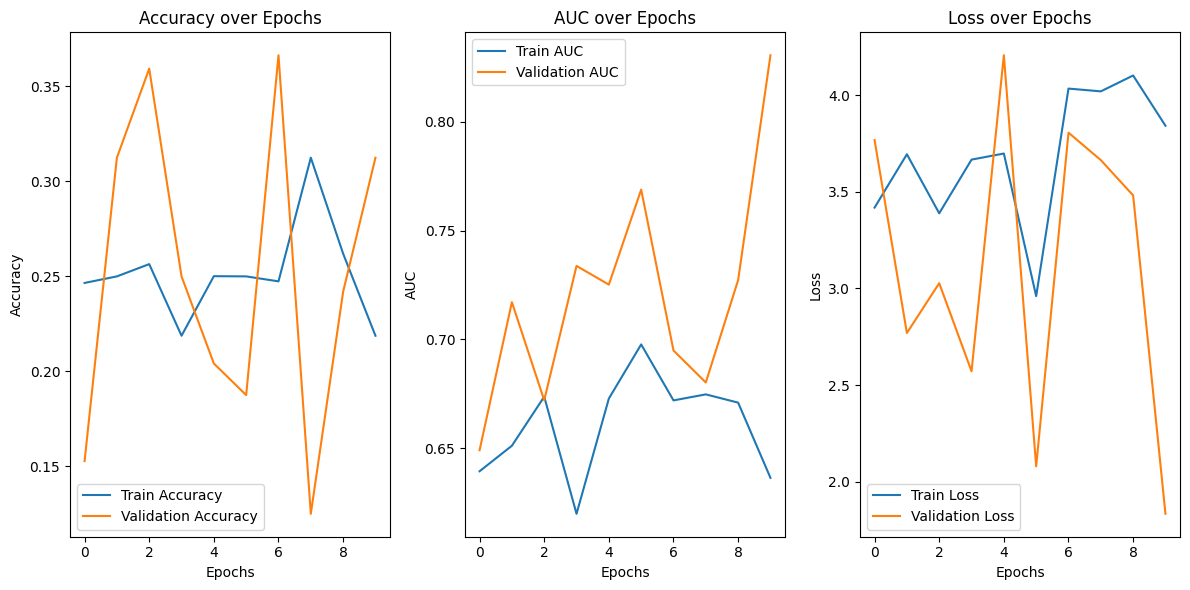

In [76]:
plot_training_history(history)

In [77]:
test_generator.reset() 
predictions = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [78]:
mlb = MultiLabelBinarizer()

true_classes_binary = mlb.fit_transform(true_classes)
predicted_classes_binary = mlb.transform(predicted_classes)

print("Classification Report:")
print(classification_report(true_classes_binary, predicted_classes_binary, target_names=test_generator.class_indices.keys()))

Classification Report:
                  precision    recall  f1-score   support

     Atelectasis       0.58      1.00      0.74        80
    Cardiomegaly       0.51      0.51      0.51        68
   Consolidation       0.00      0.00      0.00        33
           Edema       0.00      0.00      0.00        45
Pleural Effusion       0.00      0.00      0.00        67

       micro avg       0.56      0.39      0.46       293
       macro avg       0.22      0.30      0.25       293
    weighted avg       0.28      0.39      0.32       293
     samples avg       0.54      0.39      0.43       293

